## Proyecto de Clasificación de Imágenes de F1 - Modelo 3: Híbrido CNN-ViT con Keras

**Autor:** Gerónimo Pautazzo
**Fecha:** 14 de Octubre de 2025

### Objetivo del Notebook

En este notebook se construye un modelo híbrido avanzado que combina una Red Neuronal Convolucional (CNN) con un **Vision Transformer (ViT)**. La hipótesis es que podemos mejorar el rendimiento del modelo CNN simple aprovechando su capacidad para extraer características locales y complementándola con la habilidad de los Transformers para analizar el contexto y las relaciones globales en la imagen.

El proceso es el siguiente:
1.  Reutilizar el pipeline de datos de Keras.
2.  Definir los componentes de un Vision Transformer como capas personalizadas.
3.  **Utilizar el modelo CNN optimizado de la Fase 1 como un "backbone"** o extractor de características especializado.
4.  Ensamblar el modelo híbrido, optimizar sus hiperparámetros con **Keras Tuner** y evaluar su rendimiento final.

In [ ]:
#Herramientas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

#Sklearn
from sklearn.metrics import confusion_matrix, classification_report

#Tensorflow/Keras
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential 
from tensorflow.keras.callbacks import EarlyStopping
print("Versión de TensorFlow:", tf.__version__)

#Tuner
import keras_tuner as kt


# Suprime las advertencias generales de Python
warnings.filterwarnings('ignore')
# Suprime los mensajes informativos de TensorFlow (INFO y WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Versión de TensorFlow: 2.19.0


In [3]:
# Reutilizacion de parametros globales
DATA_DIR = "C:/Users/Urano/OneDrive/Escritorio/RoadMap/Proyectos CV/Clasificacion DL CNN- ViT/datos"
IMAGE_SIZE = (224, 224) #El tamaño de redimension de las images
BATCH_SIZE = 16 # Numero de imagenes que se procesan por cada paso/lote
#EPOCHS = 5 # Numero de veces que el modelo vera el dataset completo
VALIDATION_SPLIT = 0.2 # 20% DE DATOS PARA VALIDACION
SEED = 42 # Semilla de reproducibilidad

#Carga de datos 
train_dataset, validation_dataset =tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="categorical",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VALIDATION_SPLIT,
    subset="both"
)

class_names=train_dataset.class_names
NUM_CLASSES=len(class_names)
print(f"Clases encontradas: {class_names}")


Found 153 files belonging to 3 classes.
Using 123 files for training.
Using 30 files for validation.
Clases encontradas: ['crash', 'f1', 'safety_car']


In [4]:
#Data Augmentation y Optimizacion

data_augmentation=Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
], name="data_augmentation")

AUTOTUNE = tf.data.AUTOTUNE
train_dataset_final = train_dataset.map(
    lambda img, lbl: (data_augmentation(img, training=True), lbl),
    num_parallel_calls=AUTOTUNE
).cache().prefetch(buffer_size=AUTOTUNE)

validation_dataset_final = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

print("\n¡Pipeline de datos listo!")


¡Pipeline de datos listo!


Mostrando una muestra de imágenes del conjunto de entrenamiento:


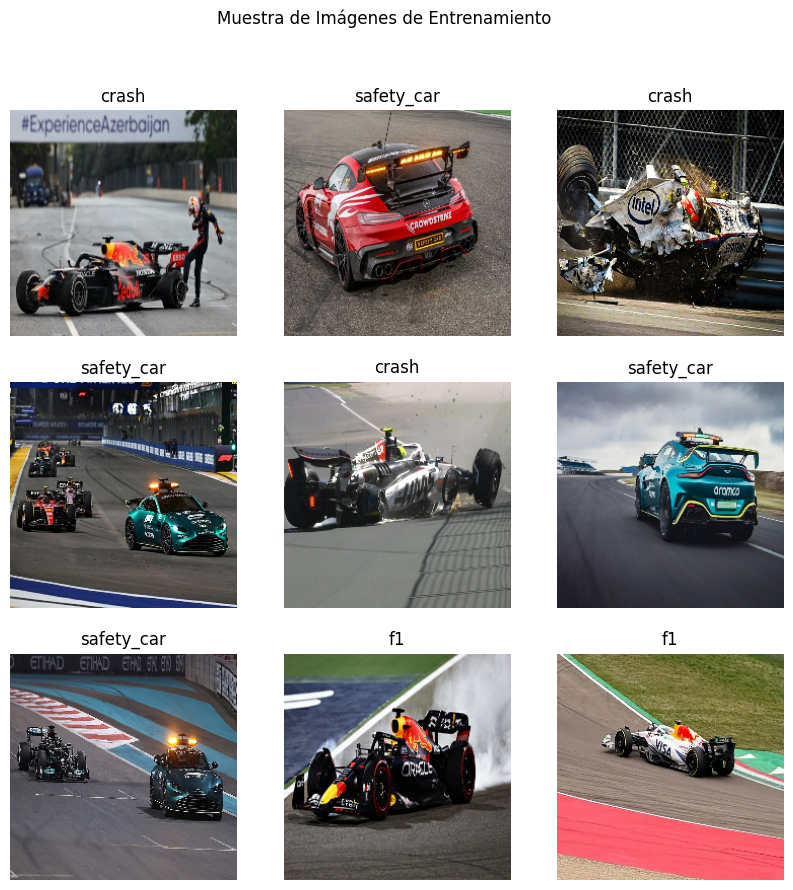

In [5]:
#Muestra de Imágenes

print("Mostrando una muestra de imágenes del conjunto de entrenamiento:")
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
plt.suptitle("Muestra de Imágenes de Entrenamiento")
plt.show()


Calculando la distribución de clases...


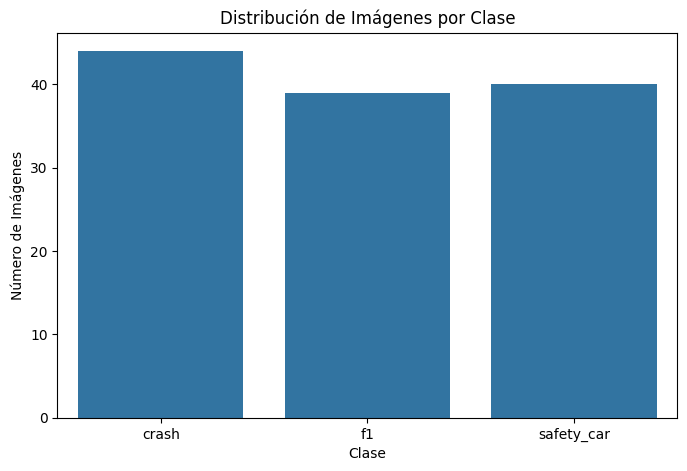

In [6]:
#Distribución de Clases

print("\nCalculando la distribución de clases...")
labels = np.concatenate([y for x, y in train_dataset], axis=0)
class_counts = np.sum(labels, axis=0)

plt.figure(figsize=(8, 5))
sns.barplot(x=class_names, y=class_counts)
plt.title('Distribución de Imágenes por Clase')
plt.ylabel('Número de Imágenes')
plt.xlabel('Clase')
plt.show()

In [7]:
def plot_training_history(history):
    """
    Función para graficar las curvas de precisión y pérdida del entrenamiento.
    Recibe el objeto 'history' devuelto por el método model.fit().
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 6))

    # Gráfico de Precisión
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Precisión de Entrenamiento')
    plt.plot(epochs_range, val_acc, label='Precisión de Validación')
    plt.legend(loc='lower right')
    plt.title('Precisión de Entrenamiento y Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')

    # Gráfico de Pérdida
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Pérdida de Entrenamiento')
    plt.plot(epochs_range, val_loss, label='Pérdida de Validación')
    plt.legend(loc='upper right')
    plt.title('Pérdida de Entrenamiento y Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')

    plt.suptitle('Análisis del Historial de Entrenamiento', fontsize=16)
    plt.show()

print("Función 'plot_training_history' definida. Lista para ser usada después del entrenamiento.")


Función 'plot_training_history' definida. Lista para ser usada después del entrenamiento.


### Construcción de los Componentes del Vision Transformer (ViT)

Para construir nuestro modelo híbrido, primero necesitamos definir los bloques de construcción fundamentales del Vision Transformer como capas personalizadas de Keras.
+ AddPositionEmbedding
+ TransformerBlock

In [8]:
# Construccion de los componentes de Vision Transformer (ViT)

#Componente 1: Positional Embedding (Capa de incrustacio Posicional)
@tf.keras.utils.register_keras_serializable(package="Custom")
class AddPositionEmbedding(layers.Layer):
    def __init__(self, num_patches, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.embed_dim = embed_dim
        # Usamos palabras clave para cada argumento para ser explícitos
        self.pos_embedding = self.add_weight(
            name="pos_embedding",
            shape=(1, num_patches, embed_dim),
            initializer="random_normal",
            trainable=True,
        )

    def call(self, tokens):
        return tokens + self.pos_embedding

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "embed_dim": self.embed_dim,
        })
        return config
    
#Componenete 2: Transfomer Block (Bloque Codificador del Transformer)
@tf.keras.utils.register_keras_serializable(package="Custom")
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        # Capa de Atención Multicanal (nativa de Keras)
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        # La red neuronal "feed-forward" (MLP)
        self.mlp = Sequential([
            layers.Dense(mlp_dim, activation="gelu"),
            layers.Dropout(dropout),
            layers.Dense(embed_dim),
            layers.Dropout(dropout),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Primera parte: Mecanismo de Atención + Conexión Residual
        attention_output = self.attention(inputs, inputs)
        out1 = self.layernorm1(inputs + attention_output)
        # Segunda parte: Red Neuronal (MLP) + Conexión Residual
        mlp_output = self.mlp(out1)
        return self.layernorm2(out1 + mlp_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "mlp_dim": self.mlp_dim,
        })
        return config
print("Componentes del Vision Transformer definidos: AddPositionEmbedding y TransformerBlock.")


Componentes del Vision Transformer definidos: AddPositionEmbedding y TransformerBlock.


In [9]:
#Cargar el Modelo CNN ya entrenado en la pt1
#Es un Extractor de caracteriosticas especializado para este data set
print("Cargando el modelo CNN pre-entrenado (f1_classifier_keras_cnn.h5)...")
cnn_model_trained = tf.keras.models.load_model("f1_classifier_keras_cnn.h5")

#Backbone Apartir del modelo cargodo (capas CNN)
#Extraer la salida de una capa intermedia, antes del cabezal de clasificación original.
cnn_backbone= Model(
    inputs = cnn_model_trained.input,
    outputs= cnn_model_trained.get_layer("top_conv").output,
    name= "cnn_backbone"
    )

print("Backbone CNN extraído con éxito.")


Cargando el modelo CNN pre-entrenado (f1_classifier_keras_cnn.h5)...


Backbone CNN extraído con éxito.


In [10]:
#Funcion constructora del modelo Hibrido
def build_hybrid_model(cnn_backbone, num_transformer_layers, num_heads, mlp_dim, num_classes):
    cnn_backbone.trainable = False
    inputs = cnn_backbone.input
    feature_maps = cnn_backbone.output

    _, H, W, C = feature_maps.shape

    patches = layers.Reshape((H * W, C))(feature_maps)
    encoded_patches = AddPositionEmbedding(H * W, C)(patches)

    x = encoded_patches
    for _ in range(num_transformer_layers):
        x = TransformerBlock(embed_dim=C, num_heads=num_heads, mlp_dim=mlp_dim)(x)

    # --- LINEA CORREGIDA ---
    representation = layers.GlobalAveragePooling1D()(x) # Note the extra ()

    representation = layers.Dropout(0.5)(representation)
    outputs = layers.Dense(num_classes, activation="softmax")(representation)

    return Model(inputs=inputs, outputs=outputs, name="CNN_ViT_Hybrid")

In [11]:
#Hiperparametro y Construccion del Modelo Hibrido
NUM_TRANSFORMER_LAYERS = 4
NUM_HEADS = 4
MLP_DIM = 128

# Usamos nuestra función con el backbone que extrajimos
hybrid_model = build_hybrid_model(
    cnn_backbone=cnn_backbone,
    num_transformer_layers=NUM_TRANSFORMER_LAYERS,
    num_heads=NUM_HEADS,
    mlp_dim=MLP_DIM,
    num_classes=NUM_CLASSES
)

# Compilamos el modelo para prepararlo para el entrenamiento
hybrid_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

#Visualizacionde la arquitectura
print("\nModelo Híbrido construido y compilado. A continuación, el resumen:")



Modelo Híbrido construido y compilado. A continuación, el resumen:


In [12]:
hybrid_model.summary()

Model: "CNN_ViT_Hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 110,372,006 (421.04 MB)

 Trainable params: 106,327,555 (405.61 MB)

 Non-trainable params: 4,044,451 (15.43 MB)

In [ ]:
print("\nIniciando el entrenamiento del modelo híbrido...")

#Definicion del callback de earlystopping
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=1,
    restore_best_weights=True
)

#Entrenamiento del Modelo
history_hybrid = hybrid_model.fit(
    train_dataset_final,
    epochs=30,
    validation_data=validation_dataset_final,
    callbacks=[early_stopping]
)

print("\n--- Entrenamiento Finalizado. Mostrando resultados... ---")


Iniciando el entrenamiento del modelo híbrido...
Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.3712 - loss: 7.2702 - val_accuracy: 0.2333 - val_loss: 4.3633
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.3260 - loss: 2.8390 - val_accuracy: 0.3667 - val_loss: 1.7245
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.2611 - loss: 1.9890 - val_accuracy: 0.4000 - val_loss: 1.1916
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.3678 - loss: 1.5788 - val_accuracy: 0.3667 - val_loss: 1.3503
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.3011 - loss: 1.7083 - val_accuracy: 0.4000 - val_loss: 1.1020
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.2993 - loss: 1.4045 - val_accuracy: 0.2333 - val_loss: 1.1352
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.3176 - loss: 1.4065 - val_accuracy: 0.3667 - val_loss: 1.1427
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.2551 - loss: 1.6254 


Entrenamiento Finalizado. Mostrando resultados...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step - accuracy: 0.4125 - loss: 1.0858

Precisión final en validación: 40.00%


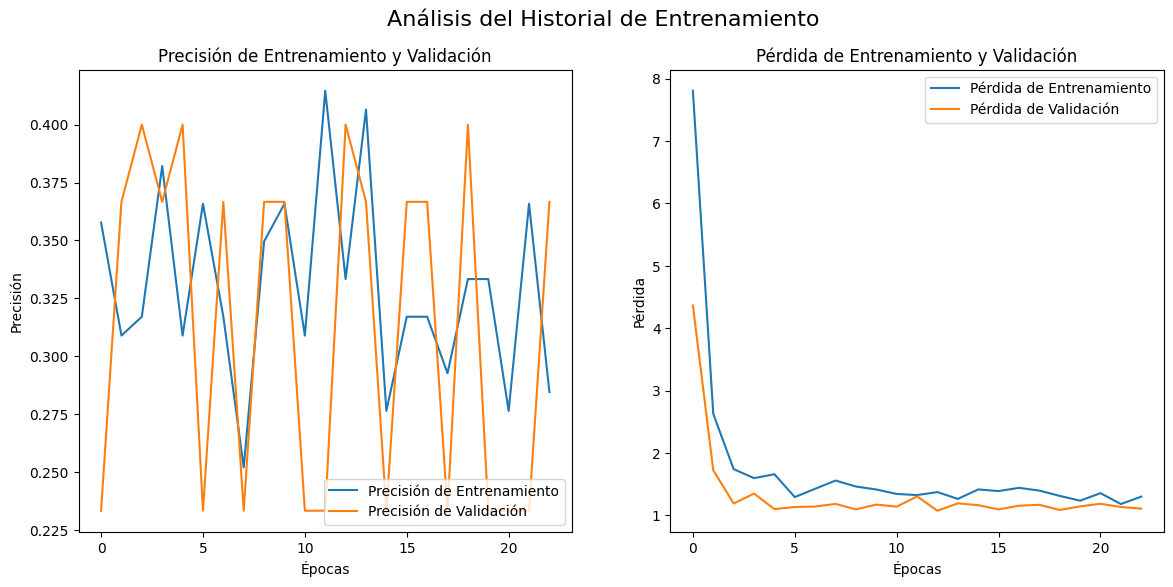

In [14]:
#Evaluacion de Rendimiento
print("\nEntrenamiento Finalizado. Mostrando resultados...")
loss, accuracy = hybrid_model.evaluate(validation_dataset_final)
print(f"\nPrecisión final en validación: {accuracy * 100:.2f}%")

plot_training_history(history_hybrid)

# Guardamos el modelo híbrido final
#hybrid_model.save('f1_classifier_keras_hybrid.h5')
#print("\nModelo híbrido final guardado como 'f1_classifier_keras_hybrid.h5'")

Generando análisis detallado del modelo híbrido...


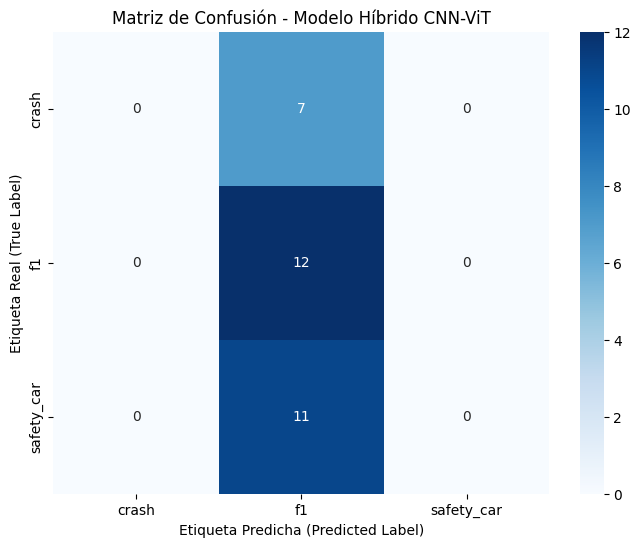


     REPORTE DE CLASIFICACIÓN - MODELO HÍBRIDO CNN-ViT
              precision    recall  f1-score   support

       crash       0.00      0.00      0.00         7
          f1       0.40      1.00      0.57        12
  safety_car       0.00      0.00      0.00        11

    accuracy                           0.40        30
   macro avg       0.13      0.33      0.19        30
weighted avg       0.16      0.40      0.23        30



In [ ]:
print("Generando análisis detallado del modelo híbrido...")

# Predicciones y las Etiquetas Reales 
y_pred = []
y_true = []

# Iterar sobre el dataset de validación para obtener las predicciones
for images, labels in validation_dataset_final:
    # Hacemos predicciones para el lote actual
    preds = hybrid_model.predict(images, verbose=0)
    # Convertimos las predicciones (probabilidades) y etiquetas (one-hot) a etiquetas de clase (0, 1, 2)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

#Visualizacion la Matriz de Confusión 
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Etiqueta Predicha (Predicted Label)')
plt.ylabel('Etiqueta Real (True Label)')
plt.title('Matriz de Confusión - Modelo Híbrido CNN-ViT')
plt.show()

# Reporte de Clasificación ---
# Este reporte nos da las métricas que buscabas: precision, recall y f1-score.
print("\n" + "="*60)
print("     REPORTE DE CLASIFICACIÓN - MODELO HÍBRIDO CNN-ViT")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names))
print("="*60)

Probablementte se trate de un colapso de modo (mode collapse). El modelo no está aprendiendo y encontro un "atajo" muy simple: predecir siempre la clase más común en este caso _"f1"_

In [ ]:
#Optimizacion de hiper parametros con keras tuner
def build_hyper_hybrid_model(hp):
    """
    Función que define el modelo híbrido y el espacio de búsqueda para Keras Tuner.
    """
    # Espacio de búsqueda de hiperparámetros
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-3, 1e-4, 1e-5])
    hp_num_transformer_layers = hp.Int("num_transformer_layers", min_value=2, max_value=6, step=2) 
    hp_mlp_dim = hp.Choice("mlp_dim", values=[128, 256])
    hp_dropout = hp.Float("dropout", min_value=0.2, max_value=0.5, step=0.1)

    # Backbone a partir del modelo entrenado
    cnn_model_trained = tf.keras.models.load_model("f1_classifier_keras_cnn.h5")
    
    cnn_backbone = Model(
        inputs=cnn_model_trained.input, 
        outputs=cnn_model_trained.get_layer("top_conv").output,
        name="cnn_backbone"
    )
    cnn_backbone.trainable = False

    # Modelo híbrido con hiperparámetros del trial
    inputs = cnn_backbone.input
    feature_maps = cnn_backbone.output
    _, H, W, C = feature_maps.shape
    patches = layers.Reshape((H * W, C))(feature_maps)
    encoded_patches = AddPositionEmbedding(H * W, C)(patches)

    x = encoded_patches
    for _ in range(hp_num_transformer_layers):
        x = TransformerBlock(embed_dim=C, num_heads=NUM_HEADS, mlp_dim=hp_mlp_dim)(x)

    representation = layers.GlobalAveragePooling1D()(x)
    representation = layers.Dropout(hp_dropout)(representation) 
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(representation)

    hybrid_model = Model(inputs=inputs, outputs=outputs)

    # Compilación del Modelo
    hybrid_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), 
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return hybrid_model


In [23]:
# Ejecutar keras tuner
tuner_hybrid = kt.RandomSearch(
    build_hyper_hybrid_model,
    objective="val_accuracy",
    max_trials=10,
    directory="keras_tuner_hybrid_dir",
    project_name="f1_hybrid_classification"
)

print("\nIniciando la búsqueda de hiperparámetros para el modelo híbrido...")
tuner_hybrid.search(
    train_dataset_final,
    epochs=15,
    validation_data=validation_dataset_final
)

# Mostrar los Mejores Resultados
best_hps_hybrid = tuner_hybrid.get_best_hyperparameters(num_trials=1)[0]

print("\n" + "="*60)
print("     ¡BÚSQUEDA COMPLETADA PARA EL MODELO HÍBRIDO!")
print("="*60)
print("Los mejores hiperparámetros encontrados son:")
for param, value in best_hps_hybrid.values.items():
    print(f"- {param}: {value}")
print("="*60)

Trial 10 Complete [00h 03m 54s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 01h 11m 29s

     ¡BÚSQUEDA COMPLETADA PARA EL MODELO HÍBRIDO!
Los mejores hiperparámetros encontrados son:
- learning_rate: 0.0001
- num_transformer_layers: 4
- mlp_dim: 128
- dropout: 0.30000000000000004


In [29]:
# Entrenamiento y Evaluacion final del modelo hibrido

#Modelo final con mejore hiperparametros 
best_hps_hybrid = tuner_hybrid.get_best_hyperparameters(num_trials=1)[0]
final_hybrid_model = tuner_hybrid.hypermodel.build(best_hps_hybrid)

print("Modelo Híbrido Final Construido con los Hiperparámetros Óptimos")
#final_hybrid_model.summary()

#Entrenamiento Modelo Final
print("\nIniciando el entrenamiento del modelo híbrido final...")
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=1,
    restore_best_weights=True
)

history_final_hybrid = final_hybrid_model.fit(
    train_dataset_final,
    epochs=50,
    validation_data=validation_dataset_final,
    callbacks=[early_stopping] 
)


Modelo Híbrido Final Construido con los Hiperparámetros Óptimos

Iniciando el entrenamiento del modelo híbrido final...
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.4944 - loss: 2.0953 - val_accuracy: 0.9333 - val_loss: 0.1225
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.8461 - loss: 0.4416 - val_accuracy: 0.8667 - val_loss: 0.2913
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.8393 - loss: 0.5001 - val_accuracy: 0.9667 - val_loss: 0.0918
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.9590 - loss: 0.1056 - val_accuracy: 0.9667 - val_loss: 0.0985
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.9777 - loss: 0.0795 - val_accuracy: 0.9333 - val_loss: 0.1314
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.9947 - loss: 0.0177 - val_accuracy: 0.9667 - val_loss: 0.0796
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9333 - val_loss: 0.1695
Epoch 8/50
8


Entrenamiento Finalizado. Mostrando gráficos de rendimiento...


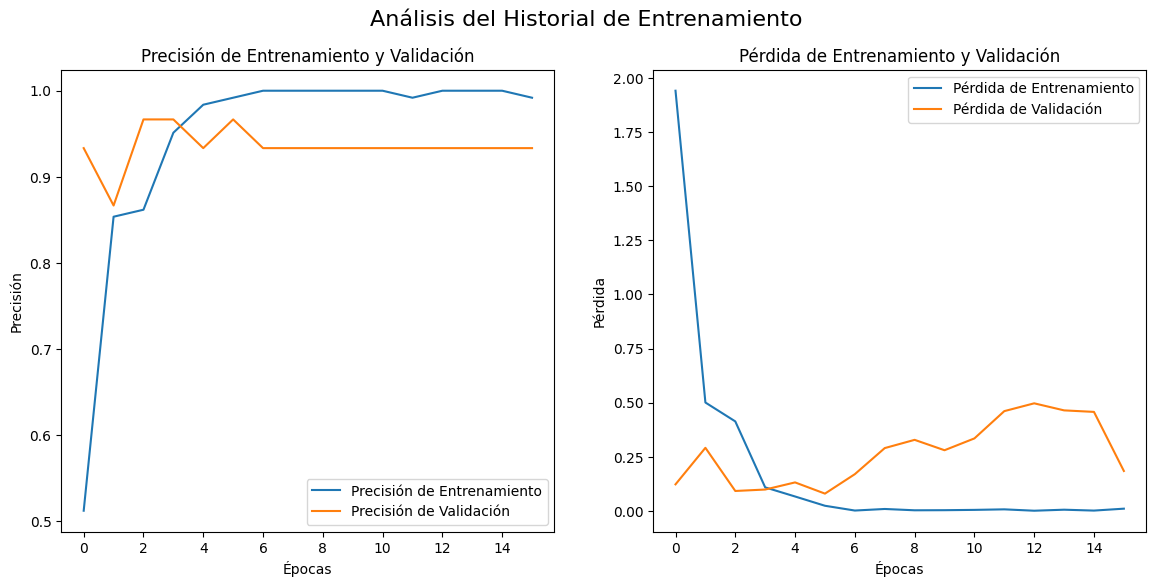


Generando Análisis Detallado (Métricas Finas)...


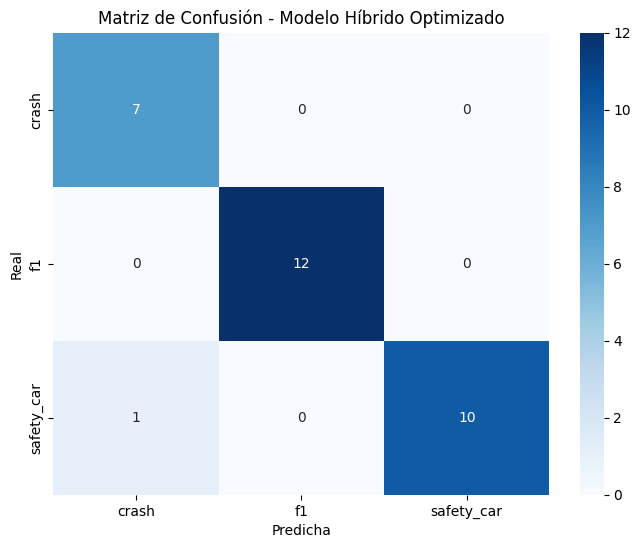


     REPORTE DE CLASIFICACIÓN - MODELO HÍBRIDO OPTIMIZADO
              precision    recall  f1-score   support

       crash       0.88      1.00      0.93         7
          f1       1.00      1.00      1.00        12
  safety_car       1.00      0.91      0.95        11

    accuracy                           0.97        30
   macro avg       0.96      0.97      0.96        30
weighted avg       0.97      0.97      0.97        30



In [30]:
#Graficos de Rendimiento
print("\nEntrenamiento Finalizado. Mostrando gráficos de rendimiento...")
plot_training_history(history_final_hybrid)

#Metricas
print("\nGenerando Análisis Detallado (Métricas Finas)...")
y_pred_hybrid = []
y_true_hybrid = []

for images, labels in validation_dataset_final:
    preds = final_hybrid_model.predict(images, verbose=0)
    y_pred_hybrid.extend(np.argmax(preds, axis=1))
    y_true_hybrid.extend(np.argmax(labels.numpy(), axis=1))

#Matris de confusion
conf_matrix_hybrid = confusion_matrix(y_true_hybrid, y_pred_hybrid)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_hybrid, annot=True, fmt='g', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicha')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Modelo Híbrido Optimizado')
plt.show()

print("\n" + "="*60)
print("     REPORTE DE CLASIFICACIÓN - MODELO HÍBRIDO OPTIMIZADO")
print("="*60)
print(classification_report(y_true_hybrid, y_pred_hybrid, target_names=class_names))
print("="*60)

In [35]:
#Guardar el Modelo Final
final_hybrid_model.save('f1_classifier_keras_hybrid.keras')
print("\nModelo híbrido final guardado como 'f1_classifier_keras_hybrid.'")


Modelo híbrido final guardado como 'f1_classifier_keras_hybrid.'


### Resultados: Modelo Híbrido Optimizado

La optimización de hiperparámetros del modelo híbrido CNN-ViT ha sido un éxito, resultando en un clasificador de muy alto rendimiento con una precisión general del __97%__.

### Análisis Detallado del Rendimiento:
* Dominio de la Clase f1: El modelo ha alcanzado un rendimiento __perfecto__ para la clase f1, con un 100% tanto en precisión como en recall. Esto indica que no solo identifica correctamente todos los monoplazas, sino que *nunca los confunde* con otra clase.

* Alta Fiabilidad (Precisión): La precisión es excelente en todas las clases. Cuando el modelo predice f1 o safety_car, su acierto es del __100%__. Esto lo convierte en una herramienta __muy fiable__ para identificar estas dos categorías.

* Alta Sensibilidad (Recall): El modelo demuestra una gran __capacidad__ para encontrar las __imágenes correctas__, identificando el __100%__ de los crash y el __91%__ de los safety_car.

* Único Punto de Mejora:
El análisis revela que el *único punto de confusión menor* del modelo ocurre al clasificar un safety_car, que en una ocasión fue incorrectamente etiquetado como crash. Esto se refleja en la precisión de crash __(88%)__ y el recall de safety_car __(91%)__.


## Conclusión del Notebook

La optimización del modelo híbrido fue un éxito rotundo, alcanzando una precisión final del **97%**. Este resultado, superior al del modelo CNN simple, valida la hipótesis de que la arquitectura híbrida es más potente para este problema de clasificación. El modelo ha sido guardado como `f1_classifier_keras_hybrid_OPTIMIZED.keras` y se posiciona como el mejor candidato hasta ahora en el proyecto.